c:\Users\manu pachauri\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:37:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9933352926938902
ROC AUC: 0.9994494485858941

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270881
           1       0.16      1.00      0.28      1643

    accuracy                           0.99   1272524
   macro avg       0.58      0.99      0.64   1272524
weighted avg       1.00      0.99      1.00   1272524



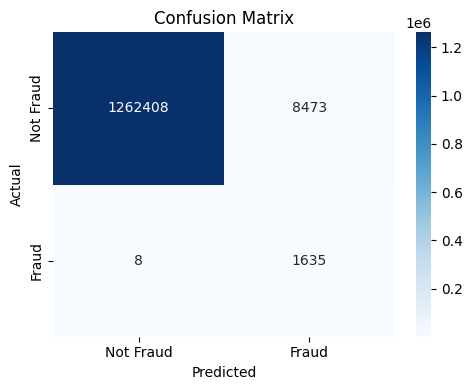

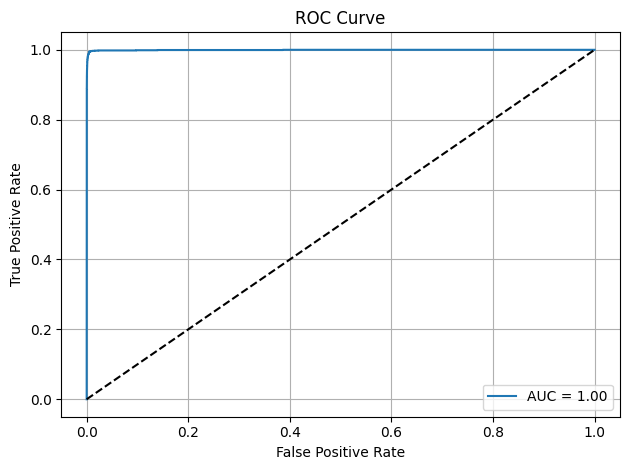

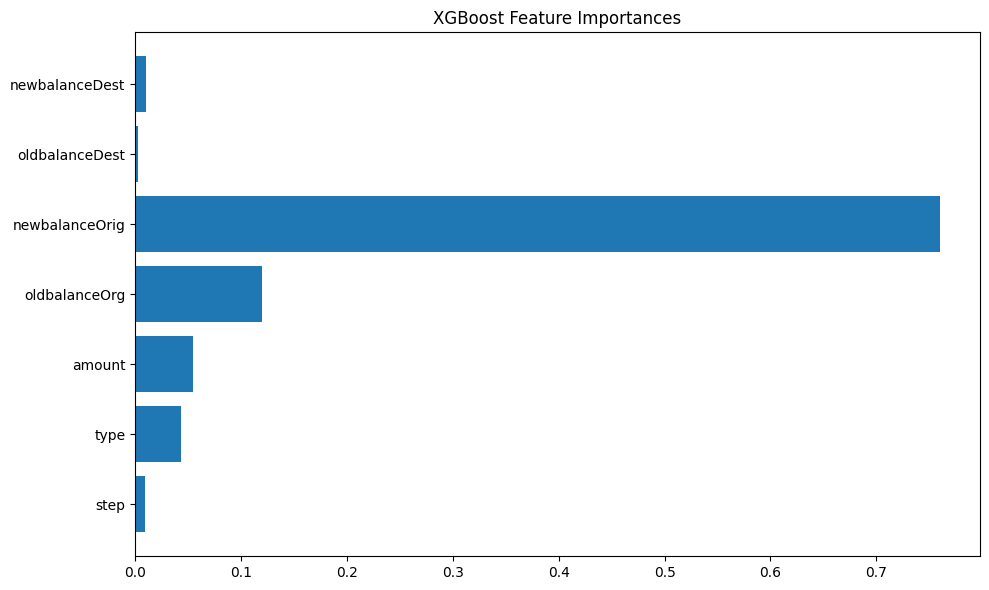

Sample Prediction: Not Fraud


In [3]:


# Improved Financial Fraud Detection using XGBoost + SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Load data
data = pd.read_csv("PS_20174392719_1491204439457_log.csv")
data.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

# Encode 'type'
data['type'] = LabelEncoder().fit_transform(data['type'])

# Drop flagged column (irrelevant)
data.drop(['isFlaggedFraud'], axis=1, inplace=True)

# Feature & target split
X = data.drop('isFraud', axis=1)
y = data['isFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handle imbalance with SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# Normalize
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)

# XGBoost model with tuned params
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', learning_rate=0.1, max_depth=6, n_estimators=100)
model.fit(X_res_scaled, y_res)

# Predict
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Feature Importance
plt.figure(figsize=(10, 6))
importances = model.feature_importances_
plt.barh(X.columns, importances)
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

# Sample prediction
sample = pd.DataFrame([X.iloc[0]], columns=X.columns)

sample_scaled = scaler.transform(sample)
sample_pred = model.predict(sample_scaled)
print("Sample Prediction:", "Fraud" if sample_pred[0] == 1 else "Not Fraud")
